**Head2Toe**：it combines the advantages of linear probing and fine-tuning. It selects features from all layers of the model to train a classification head for the target-domain. It takes all the pre-trained layers' outputs, and then apply a linear layer to predict final output. The goal is to imporve transfer learning. 

Reference: https://github.com/google-research/head2toe

In [1]:
# install task adaptation
!pip install git+https://github.com/google-research/task_adaptation.git#egg=task_adaptation

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/google-research/task_adaptation.git to /tmp/pip-install-f2yivt2i/task-adaptation_b0bf6a991b4545d192c3ff3814c8ee1c
  Running command git clone -q https://github.com/google-research/task_adaptation.git /tmp/pip-install-f2yivt2i/task-adaptation_b0bf6a991b4545d192c3ff3814c8ee1c
     |████████████████████████████████| 4.8 MB 56.8 MB/s 
     |████████████████████████████████| 1.1 MB 62.3 MB/s 
  Created wheel for task-adaptation: filename=task_adaptation-0.1-py3-none-any.whl size=89354 sha256=edc5fc0edfb592ef652679b27525ea3d67b54e54acc06a13bf28d089538587b1
  Stored in directory: /tmp/pip-ephem-wheel-cache-_r7csy46/wheels/d4/4f/a1/e4972f2a7d817b3b3db7060c5beb503dee1da479b5ada2028c
Successfully built task-adaptation


In [2]:
# install ml collections
!pip install ml_collections

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 77 kB 6.4 MB/s 
  Created wheel for ml-collections: filename=ml_collections-0.1.1-py3-none-any.whl size=94524 sha256=4f8bf9bd8b12c88ea890e96a4d073488a0e319371158489f63b0b57848d56001
  Stored in directory: /root/.cache/pip/wheels/b7/da/64/33c926a1b10ff19791081b705879561b715a8341a856a3bbd2
Successfully built ml-collections


Model with Fune-Tuning

In [3]:
# coding=utf-8
# Copyright 2022 Head2Toe Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

r"""Finetune models for multi-backone inputs.
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import copy
import math
from absl import logging
import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_hub as hub
# nohidden: just output layer.
# random_100: 1 non-trainable hidden layer with 100 units.
# random_1000: ... with 1000 units.
# trainable_100: 1 trainable hidden layer with 100 units.
# trainable_1000: ... with 1000 units.
OUTPUT_HEAD_TYPES = ['nohidden', 'random', 'trainable']


def zero_aware_normalize(embedding, axis):
  """If the norm is zero leaves the row unnormalized."""
  # Following will have nans when the norm of vector(the divider) is zero.
  normalized, norms = tf.linalg.normalize(embedding, axis=axis)
  is_zero_norm = tf.broadcast_to(tf.equal(norms, 0), normalized.shape)
  return tf.where(is_zero_norm, tf.zeros_like(embedding), normalized)


def _check_and_convert(norm_ord):
  """Validates the order is positive or 'inf'."""
  if isinstance(norm_ord, (float, int)) and norm_ord > 0:
    return norm_ord
  elif isinstance(norm_ord, str) and norm_ord == 'inf':
    return np.inf
  else:
    raise ValueError(f'norm_order:{norm_ord} is not valid')


class GroupLRP(tf.keras.regularizers.Regularizer):
  """A regularizer that applies Group L-r/p penalty to the weights.

  The L-r/p regularization penalty is computed as:
  `loss = coef * norm(norm(x, ord=r, axis=1), ord=p)`

  Attributes:
      coef: Float; regularization factor.
      r: int, Must be >0. or 'inf'
      p: int, Must be >0. or 'inf'
      group_sizes: iterable or None; used to split feature vector into tensors.
  """

  def __init__(self, coef=0., r=2, p=1, group_sizes=None):
    self.coef = tf.keras.backend.cast_to_floatx(coef)
    self.r = _check_and_convert(r)
    self.p = _check_and_convert(p)
    self.group_sizes = group_sizes

  def __call__(self, x):
    regularization = tf.keras.backend.constant(0., dtype=x.dtype)
    if self.coef:
      if self.group_sizes:
        group_norms = []
        for group in tf.split(x, self.group_sizes, axis=0):
          group_norms.append(tf.norm(tf.reshape(group, [-1]), ord=self.r))
        regularization += tf.norm(tf.stack(group_norms), ord=self.p)
      else:
        regularization += self.coef * tf.norm(
            tf.norm(x, axis=1, ord=self.r), ord=self.p)
    return regularization

  def get_config(self):
    return {'coef': float(self.coef), 'r': self.r, 'p': self.p,
            'group_sizes': tuple(self.group_sizes)}


class Finetune(tf.keras.Model):
  """A `tf.keras.Model` implementation of Finetune.

  This learner trains a linear classifier on top of the features given.
  TODO Split finetune_backbone implementation from linear probe.
  """

  def __init__(self, config):
    """Initializes a `Finetune` instance.

    Args:
      config: a `ConfigDict` specifying the backbones configuration.
    """
    super(Finetune, self).__init__()
    self._backbone_config = config.backbone
    self._learning_config = config.learning
    available_gpus = tf.config.list_physical_devices(device_type='GPU')
    if config.max_num_gpus > len(available_gpus):
      logging.warning('config.max_num_gpus: %s > n_gpus', config.max_num_gpus)
    else:
      available_gpus = available_gpus[:config.max_num_gpus]
    logging.info('N_GPUS: %d in use', len(available_gpus))
    # To get /physical_device:GPU:0
    available_gpus = [':'.join(g.name.split(':')[1:]) for g in available_gpus]
    self.strategy = tf.distribute.MirroredStrategy(devices=available_gpus)
    with self.strategy.scope():
      res = self.load_backbones()
      self.backbones, self.backbone_names, self.embedding_sizes = res

  def load_backbones(self):
    backbone_config = self._backbone_config
    # Load pre-trained backbones.
    backbones = []
    backbone_names = []
    embedding_sizes = []
    for name, handle, signature, output_key, size in zip(
        backbone_config.names,
        backbone_config.handles,
        backbone_config.signatures,
        backbone_config.output_keys,
        backbone_config.input_sizes):

      if self._learning_config.finetune_backbones:
        backbone = hub.KerasLayer(handle, trainable=True)
      elif signature is None:
        backbone = hub.KerasLayer(handle, trainable=False)
      else:
        backbone = hub.KerasLayer(
            handle, signature=signature, output_key=None,
            trainable=False, signature_outputs_as_dict=True)
      inputs = tf.keras.Input(shape=(None, None, 3))
      resized_inputs = inputs
      if size is not None:
        inputs = tf.keras.Input(shape=(size, size, 3))
        resized_inputs = tf.image.resize(inputs, size=[size, size])
      outputs = backbone(resized_inputs)
      if backbone_config.additional_features:
        updated_outputs = []
        all_output_keys = [output_key]
        if backbone_config.include_input:
          outputs['input'] = resized_inputs
          all_output_keys.append('input')
        all_output_keys.extend(
            backbone_config.additional_features.strip().split(','))
        if backbone_config.additional_features_multi_target_sizes:
          t_sizes = backbone_config.additional_features_multi_target_sizes
          target_embedding_sizes = t_sizes.strip().split(',')
        else:
          target_embedding_sizes = [
              backbone_config.additional_features_target_size]
        # TODO Probably use the function to get multiple pooled features.
        # It should also return the names maybe.
        # Also it might be more straight forward to use pool_sizes.
        for target_embedding_size in target_embedding_sizes:
          new_outputs = flatten_and_concat(
              outputs, output_keys=all_output_keys,
              pool_size=backbone_config.additional_features_pool_size,
              target_size=int(target_embedding_size),
              cls_token_pool=backbone_config.cls_token_pool)
          new_names = [f'{name}_{n}_{target_embedding_size}' for n
                       in all_output_keys]
          for newname, out in zip(new_names, new_outputs):
            logging.info('Backbone name: %s, shape: %s', newname, out.shape)
            backbone_names.append(newname)
            embedding_sizes.append(out.shape[-1])
          updated_outputs += new_outputs
        outputs = updated_outputs
      else:
        outputs = outputs[output_key]
        logging.info('Backbone name: %s, shape: %s', name, outputs.shape)
        backbone_names.append(name)
        embedding_sizes.append(outputs.shape[-1])
      backbone = tf.keras.Model(inputs=inputs, outputs=outputs)
      backbones.append(backbone)
    return backbones, backbone_names, embedding_sizes

  def _get_optimizer(self, learning_config, n_classes):
    learning_rate = learning_config.learning_rate
    clipvalue = (learning_config.grad_clip_value
                 if learning_config.grad_clip_value > 0 else None)
    if learning_config.use_cosine_decay:
      learning_rate = tf.keras.experimental.CosineDecay(
          learning_rate, learning_config.training_steps)
    optimizer = learning_config.optimizer
    if optimizer == 'adam':
      optimizer = tf.optimizers.Adam(learning_rate, clipvalue=clipvalue)
    elif optimizer == 'sgd':
      optimizer = tf.optimizers.SGD(learning_rate, momentum=0.9,
                                    clipvalue=clipvalue)
    else:
      raise ValueError('Unknown optimizer')
    return optimizer

  def _embed_batch(self, x, is_training=False):
    """Compute the feature representation of a batch.

    Args:
      x: input tensor.
      is_training: bool, passed to the backbone.
    Returns:
      embedding_list: A list of tf.Tensors.
    """
    embedding_list = []
    for backbone in self.backbones:
      output_backbone = backbone(x, training=is_training)
      # Note that the output of the backbone can be a list.
      if isinstance(output_backbone, list):
        for out in output_backbone:
          embedding_list.append(out)
      else:
        embedding_list.append(output_backbone)
    return embedding_list

  def _embed_dataset(self, dataset):
    """Compute the feature representation of a batch.

    Args:
      dataset: a `tf.data.Dataset` corresponding to the support or query set.
    Returns:
      embeddings: A list of tf.Tensors.
      labels: A tf.Tensor.
    """
    batch_embedding_lists = []
    labels = []
    for x, y in dataset:
      labels.append(y)
      batch_embedding_lists.append(self._embed_batch(x))

    labels = tf.concat(labels, axis=0)
    output_embeddings = []
    for i in range(len(batch_embedding_lists[0])):
      embedding_i = [batch[i] for batch in batch_embedding_lists]
      output_embeddings.append(tf.concat(embedding_i, axis=0))
    return output_embeddings, labels

  def _process_metrics(self, metrics):
    (support_loss_iter, support_accuracy_iter, query_loss_iter,
     query_accuracy_iter) = metrics

    ret_dict = {
        'support_loss': support_loss_iter[-1],
        'support_accuracy': support_accuracy_iter[-1],
        'query_loss': query_loss_iter[-1],
        'query_accuracy': query_accuracy_iter[-1]
                }

    return ret_dict

  def _process_embeddings(self, embeddings, selected_features,
                          normalization='unit_vector'):
    """Processes embeddings by normalizing an concatenating.

    Args:
      embeddings: list of Tensors, where each Tensor is the embeddings
        of a particular backbone.
      selected_features: list of Tensors, where each Tensor indicates the
        indices to be selected.
      normalization: str, 'unit_vector', 'per_feature_std'.
        'unit_vector' SUR style normalization
        'per_feature' similar to Batch-Normalization

    Returns:
      flattened and possibly scaled embeddings.
    """
    # shape= (n_image, n_features)
    assert normalization in ('unit_vector', 'per_feature', '')
    if selected_features:
      # Following removes the backbones altogether if no feature is selected.
      embeddings = [
          tf.gather(embedding, indices, axis=1) for embedding, indices
          in zip(embeddings, selected_features)
          if np.prod(indices.shape) > 0
      ]
    if normalization == 'unit_vector':
      embeddings = [zero_aware_normalize(e, axis=1) for e in embeddings]
    embeddings = tf.concat(embeddings, -1)
    if normalization == 'per_feature':
      # Normalize each feature to have unit variance and zero mean.
      mean, var = tf.nn.moments(embeddings, axes=0)
      bn_args = {'offset': None,
                 'scale': None,
                 'variance_epsilon': 1e-5}
      embeddings = tf.nn.batch_normalization(
          embeddings, mean, var, **bn_args)
    return embeddings

  @tf.function(reduce_retracing=True)
  def _compute_loss_and_accuracy(self, output_head, logits, labels,
                                 global_batch_size=None):
    """Computes the loss and accuracy on an episode."""
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=labels, logits=logits)
    if output_head.losses:
      loss += tf.add_n(output_head.losses)
    accuracy = tf.cast(tf.equal(
        tf.math.argmax(logits, axis=1, output_type=labels.dtype),
        labels), tf.float32)
    loss = tf.nn.compute_average_loss(loss, global_batch_size=global_batch_size)
    accuracy = tf.nn.compute_average_loss(accuracy,
                                          global_batch_size=global_batch_size)
    return loss, accuracy

  def _init_training_vars(self, num_ways, learning_config):
    if learning_config.l1_regularizer or learning_config.l2_regularizer:
      regularizer = tf.keras.regularizers.L1L2(
          l1=learning_config.l1_regularizer, l2=learning_config.l2_regularizer)
    elif learning_config.group_lrp_regularizer_coef:
      group_sizes = (self.embedding_sizes
                     if learning_config.group_lrp_is_embedding else None)
      regularizer = GroupLRP(
          coef=learning_config.group_lrp_regularizer_coef,
          group_sizes=group_sizes,
          r=learning_config.group_lrp_regularizer_r,
          p=learning_config.group_lrp_regularizer_p)
    else:
      regularizer = None
    output_layers = []
    assert any(learning_config.output_head_type.startswith(t)
               for t in OUTPUT_HEAD_TYPES)
    if learning_config.output_head_type.startswith('random'):
      n_units = int(learning_config.output_head_type.split('_')[1])
      n_units = n_units if n_units > 0 else num_ways
      output_layers.append((n_units, False, 'relu'))
    elif learning_config.output_head_type.startswith('trainable'):
      n_units = int(learning_config.output_head_type.split('_')[1])
      n_units = n_units if n_units > 0 else num_ways
      output_layers.append((n_units, True, 'relu'))
    # Final layer, this is the only layer when type=nohidden.
    output_layers.append((num_ways, True, None))
    output_head = tf.keras.Sequential()
    for i, (n_features, is_trainable, f_activation) in enumerate(output_layers):
      kwargs_dense = {'trainable': is_trainable}
      if i == 0 and learning_config.output_head_zeroinit:
        logging.info('First layer in output head is zero initialized.')
        kwargs_dense['kernel_initializer'] = tf.zeros
      new_layer = tf.keras.layers.Dense(
          n_features, activation=f_activation, kernel_regularizer=regularizer,
          **kwargs_dense)
      output_head.add(new_layer)
    return output_head

  def evaluate(self, learning_config, support_dataset, query_dataset,
               **unused_kwargs):
    """Performs evaluation on an episode.

    Args:
      learning_config: a `ConfigDict` specifying the learning configuration.
      support_dataset: a `tf.data.Dataset` for the support set.
      query_dataset: a `tf.data.Dataset` for the query set.

    Returns:
      metrics: dict mapping metric names to metrics.
    """
    metrics = self._optimize_finetune(
        learning_config, support_dataset, query_dataset)
    return_dict = self._process_metrics(metrics)
    return return_dict

  def _optimize_finetune(self, learning_config, support_dataset, query_dataset,
                         selected_feature_indices=None,
                         return_output_head=False):
    """Optimize the output layers and possibly the backbones, too.

    Args:
      learning_config: A ConfigDict.
      support_dataset: a `tf.data.Dataset` for the support set.
      query_dataset: a `tf.data.Dataset` or None for the query set.
      selected_feature_indices: defines which features are selected.
      return_output_head: bool that decides what is returned. If true, this
        means we return the trained output head and also don't calculate query
        performance.
    Returns:
      lambda_logits: The optimized lambdas or None.
      support_loss_iter: A list of iterate values.
      support_accuracy_iter: A list of iterate values.
      query_loss_iter: A list of iterate values.
      query_accuracy_iter: A list of iterate values.
    """
    if selected_feature_indices:
      # Print statistics
      for name, indices in zip(self.backbone_names, selected_feature_indices):
        logging.info('Backbone: %s, selected %d', name, len(indices))
    # Pre-generate the embeddings
    with tf.device('/CPU:0'):
      support_embeddings, support_labels = self._embed_dataset(support_dataset)
      # Normalize the data
      support_representation = self._process_embeddings(
          support_embeddings, selected_feature_indices,
          normalization=learning_config.feature_normalization)
      logging.info('Support representation shape: %s',
                   support_representation.shape)
    if query_dataset is None:
      query_labels = tf.constant([], dtype=support_labels.dtype)
    elif learning_config.cached_eval:
      with tf.device('/CPU:0'):
        query_embeddings, query_labels = self._embed_dataset(query_dataset)
        query_representation = self._process_embeddings(
            query_embeddings, selected_feature_indices,
            normalization=learning_config.feature_normalization)
    else:
      # We still need query labels to get number of classes. In some situations
      # Support set might not have all classes, and then our output head
      # would be smaller, which creates NaNs in loss calculation when
      # tf.nn.sparse_softmax_cross_entropy_with_logits is used.
      all_labels = []
      for _, batch_labels in query_dataset:
        all_labels.append(batch_labels)
      query_labels = tf.concat(all_labels, axis=0)
    support_loss_iter = []
    support_accuracy_iter = []
    query_loss_iter = []
    query_accuracy_iter = []
    all_labels = tf.concat([support_labels, query_labels], 0)
    num_ways = tf.cast(tf.math.reduce_max(tf.unique(all_labels)[0]) + 1,
                       tf.int32)
    with self.strategy.scope():
      if (learning_config.finetune_backbones and
          learning_config.finetune_lr_multiplier != 1.):
        learning_config = copy.deepcopy(learning_config)
        new_lr = (learning_config['learning_rate'] *
                  learning_config.finetune_lr_multiplier)
        learning_config['learning_rate'] = new_lr
        logging.info('Finetuning learning rate is updated to %s',
                     new_lr)
      if (learning_config.finetune_backbones and
          learning_config.finetune_steps_multiplier != 1.):
        learning_config = copy.deepcopy(learning_config)
        new_steps = int(learning_config['training_steps'] *
                        learning_config.finetune_steps_multiplier)
        learning_config['training_steps'] = new_steps
        logging.info('Finetuning training steps are updated to %s', new_steps)
      optimizer = self._get_optimizer(learning_config, num_ways)
      output_head = self._init_training_vars(num_ways, learning_config)
      # Initialize the layer
      output_head(support_representation[:1])

    training_vars = output_head.trainable_variables
    if learning_config.finetune_backbones:
      for b in self.backbones:
        training_vars.extend(b.trainable_variables)
    else:
      batch_size = learning_config.train_batch_size
      # Regenerate the dataset with precomputed embeddings.
      support_dataset = tf.data.Dataset.from_tensor_slices(
          (support_representation, support_labels)).batch(batch_size)
      if query_dataset and learning_config.cached_eval:
        query_dataset = tf.data.Dataset.from_tensor_slices(
            (query_representation, query_labels)).batch(
                learning_config.eval_batch_size)
    logging.info('Trainable variables: %s', [v.name for v in training_vars])
    support_dataset = support_dataset.repeat()
    dist_support_dataset = self.strategy.experimental_distribute_dataset(
        support_dataset)
    if query_dataset:
      dist_query_dataset = self.strategy.experimental_distribute_dataset(
          query_dataset)

    @tf.function()
    def _train_step(x, y):
      with tf.GradientTape() as tape:
        if learning_config.finetune_backbones:
          # Pass the images through multiple backbones.
          embeddings = self._embed_batch(x, is_training=True)
          # Normalize the data
          x = self._process_embeddings(
              embeddings, selected_feature_indices,
              normalization=learning_config.feature_normalization)
        logits = output_head(x)
        loss, accuracy = self._compute_loss_and_accuracy(
            output_head, logits, y,
            global_batch_size=learning_config.train_batch_size)
      grads = tape.gradient(loss, training_vars)
      optimizer.apply_gradients(zip(grads, training_vars))
      return loss, accuracy

    @tf.function()
    def _eval_step(x, y):
      if (learning_config.finetune_backbones or
          not learning_config.cached_eval):
        # Pass the images through multiple backbones.
        embeddings = self._embed_batch(x, is_training=False)
        # Normalize the data
        x = self._process_embeddings(
            embeddings, selected_feature_indices,
            normalization=learning_config.feature_normalization)
      logits = output_head(x)
      loss, accuracy = self._compute_loss_and_accuracy(
          output_head, logits, y,
          global_batch_size=learning_config.eval_batch_size)
      return loss, accuracy

    for i, (x, y) in enumerate(dist_support_dataset):
      if i == learning_config.training_steps:
        break
      per_replica_results = self.strategy.run(_train_step, args=(x, y))
      pr_loss, pr_acc = per_replica_results
      support_loss = self.strategy.reduce(
          tf.distribute.ReduceOp.SUM, pr_loss, axis=None)
      support_accuracy = self.strategy.reduce(
          tf.distribute.ReduceOp.SUM, pr_acc, axis=None)
      if query_dataset and (i % learning_config.log_freq == 0 or
                            i == (learning_config.training_steps - 1)):
        logging.info('Evaluating at iteration: %d', i)
        all_losses = []
        all_accs = []
        for query_x, query_y in dist_query_dataset:
          per_replica_results = self.strategy.run(_eval_step, args=(
              query_x, query_y))
          pr_loss, pr_acc = per_replica_results
          c_query_loss = self.strategy.reduce(
              tf.distribute.ReduceOp.SUM, pr_loss, axis=None)
          c_query_accuracy = self.strategy.reduce(
              tf.distribute.ReduceOp.SUM, pr_acc, axis=None)
          all_losses.append(c_query_loss)
          all_accs.append(c_query_accuracy)
        # This assumes all batches are same size, so ensure that.
        query_loss_iter.append(np.mean(all_losses))
        query_accuracy_iter.append(np.mean(all_accs))
      support_loss_iter.append(support_loss.numpy())
      support_accuracy_iter.append(support_accuracy.numpy())
    if learning_config.finetune_backbones:
      # Reload the backbones to reset any changes made during finetuning.
      with self.strategy.scope():
        self.backbones, _, _ = self.load_backbones()
    if return_output_head:
      return output_head
    else:
      del output_head.layers[0].kernel
      return (support_loss_iter, support_accuracy_iter, query_loss_iter,
              query_accuracy_iter)


def flatten_and_concat(output_dict, output_keys, pool_size=0, target_size=0,
                       cls_token_pool='normal'):
  """Summarizes a dict of outputs into single feature vector."""
  # If target_size is given pool_size is ignored.
  if cls_token_pool not in ('normal', 'only_cls', 'nopool_cls'):
    raise ValueError("%s must be one of 'normal', 'only_cls', 'nopool_cls'"
                     % cls_token_pool)
  all_features = []
  for k in output_keys:
    output = output_dict[k]
    # TODO Make this more readable by making each branch a function.
    if len(output.shape) == 4:
      if target_size > 0:
        # Overwrite pool size so that final output matches target_size as close
        # as possible.
        _, width, _, channels = output.shape
        if channels >= target_size:
          # Global pool.
          pool_size = 0
        else:
          # Assuming square image.
          n_patches_per_row = int(math.sqrt(target_size // channels))
          pool_size = width // n_patches_per_row
      if pool_size > 0:
        output = tf.keras.layers.AveragePooling2D(
            pool_size=pool_size, strides=pool_size)(output)
        all_features.append(tf.keras.layers.Flatten()(output))
      else:
        # Global pool
        all_features.append(tf.reduce_mean(output, axis=[1, 2]))
    elif len(output.shape) == 3:
      if cls_token_pool == 'only_cls':
        output = output[:, 0, :]
      else:
        if cls_token_pool == 'nopool_cls':
          # We will get the cls as it is and pool the rest.
          cls_output, output = output[:, 0, :], output[:, 1:, :]
        if target_size > 0:
          # Overwrite pool size so that final output matches target_size as
          # close as possible.
          _, n_token, channels = output.shape
          if channels >= target_size:
            # Global pool.
            pool_size = 0
          else:
            # Assuming square image.
            n_groups = target_size / channels
            pool_size = int(n_token / n_groups)
        if pool_size > 0:
          output = tf.keras.layers.AveragePooling1D(
              pool_size=pool_size, strides=pool_size)(output)
          output = tf.keras.layers.Flatten()(output)
        else:
          # Global pool
          output = tf.reduce_mean(output, axis=[1])
        if cls_token_pool == 'nopool_cls':
          output = tf.concat([cls_output, output], axis=1)
      all_features.append(output)
    elif len(output.shape) == 2:
      all_features.append(output)
    else:
      raise ValueError(
          f'Output tensor: {k} with shape {output.shape} not 2D or 4D.')
  return all_features

In [4]:
# load dataset
dataset = tf.data.Dataset.from_tensor_slices(
    (tf.random.uniform([4, 240, 240, 3]),
      tf.random.uniform([4,], maxval=2, dtype=tf.int32))).batch(2)

In [5]:
# see dataset's overview
dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 240, 240, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [6]:
# coding=utf-8
# Copyright 2022 Head2Toe Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""Default configutation."""
import re
from ml_collections import ConfigDict


def get_config(config_string):
  train_batch_size = 128
  eval_batch_size = 50
  config = ConfigDict({
      'dataset':
          'data.caltech101',
      'eval_mode':
          'valid',
      'is_vtab_5fold_valid':
          True,
      'seed':
          8,
      'max_num_gpus':
          1,
      'learning':
          ConfigDict({
              'optimizer': 'adam',  #  adadelta, adadelta_adaptive, sgd
              'learning_rate': 0.1,
              'grad_clip_value': -1.,  # Applied if positive.
              'l1_regularizer': 0.,
              'l2_regularizer': 0.,
              'group_lrp_regularizer_coef': 0.,
              'group_lrp_regularizer_r': 2.,
              'group_lrp_regularizer_p': 1.,
              'group_lrp_is_embedding': False,
              'training_steps': 500,
              'data_fraction': 1.,
              'cached_eval': True,
              'use_cosine_decay': True,
              'train_batch_size': train_batch_size,
              'eval_batch_size': eval_batch_size,
              'finetune_backbones': False,
              'finetune_lr_multiplier': 1.,
              'finetune_steps_multiplier': 1.,
              # ('', 'unit_vector', 'per_feature')
              'feature_normalization': 'unit_vector',
              # nohidden, random_100, random_1000, trainable_100, trainable_1000
              'output_head_type': 'nohidden',
              'output_head_zeroinit': False,
              'log_freq': 50,
          }),
      'model_name':
          'Finetune'
  })

  config.backbone = get_backbone_config(config_string)
  print(f'Config backbone: {config.backbone}')
  return config


def get_backbone_config(config_string):
  """Gets backbone configuration according to the key given."""
  # Example patterns:
  # imagenetr50, imagenetr50_2x
  pattern = r'^([A-Za-z0-9]+)?_?(\d+)?x?'
  searched = re.search(pattern, config_string)
  if not searched:
    raise ValueError(f'Unrecognized config_string: {config_string}')
  added_backbone, n_repeat = searched.groups()
  print(f'Split config: {added_backbone}, {n_repeat}')
  processed_names = []
  processed_handles = []
  processed_signatures = []
  processed_output_keys = []
  input_sizes = tuple()

  if added_backbone in SINGLE_MODELS:
    n_repeat = int(n_repeat) if n_repeat else 1
    processed_names += [added_backbone] * n_repeat
    handle, size = SINGLE_MODELS[added_backbone]
    if isinstance(handle, list):
      processed_handles = handle * n_repeat
      processed_handles = processed_handles[:n_repeat]
    else:
      processed_handles += [handle] * n_repeat

    if 'vit' in added_backbone:
      processed_signatures += ['serving_default'] * n_repeat
      processed_output_keys += ['pre_logits'] * n_repeat
    else:
      processed_signatures += ['representation'] * n_repeat
      processed_output_keys += ['pre_logits'] * n_repeat
    input_sizes += (size,) * n_repeat
  else:
    raise ValueError(f'added_backbone:{added_backbone} is not recognized')

  return ConfigDict({
      'names': processed_names,
      'handles': processed_handles,
      'signatures': processed_signatures,
      'output_keys': processed_output_keys,
      'input_sizes': input_sizes,
      'include_input': False,
      'additional_features': '',
      'additional_features_pool_size': 0,
      'cls_token_pool': 'normal',
      # If target size is provided, pool size is ignored.
      'additional_features_target_size': 0,
      'additional_features_multi_target_sizes': '',
  })


SINGLE_MODELS = {
    'imagenetr50': ('imagenetr50/', 240),
    'imagenetvitB16': ('imagenetvitB16/', 224)
}

In [7]:
config = get_config('imagenetr50')

Split config: imagenetr50, None
Config backbone: additional_features: ''
additional_features_multi_target_sizes: ''
additional_features_pool_size: 0
additional_features_target_size: 0
cls_token_pool: normal
handles:
- imagenetr50/
include_input: false
input_sizes: !!python/tuple
- 240
names:
- imagenetr50
output_keys:
- pre_logits
signatures:
- representation



Apply Transfer learning

In [8]:
# download the pre-trained models and extract them
!wget -c https://storage.googleapis.com/gresearch/head2toe/imagenetr50.tar.gz
!wget -c https://storage.googleapis.com/gresearch/head2toe/imagenetvitB16.tar.gz
!tar -xvf imagenetr50.tar.gz
!tar -xvf imagenetvitB16.tar.gz
!rm *.tar.gz

--2022-10-24 05:15:36--  https://storage.googleapis.com/gresearch/head2toe/imagenetr50.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.128, 172.253.118.128, 74.125.200.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 95092185 (91M) [application/x-tar]
Saving to: ‘imagenetr50.tar.gz’

imagenetr50.tar.gz  100%[===================>]  90.69M  63.3MB/s    in 1.4s    

2022-10-24 05:15:38 (63.3 MB/s) - ‘imagenetr50.tar.gz’ saved [95092185/95092185]

--2022-10-24 05:15:38--  https://storage.googleapis.com/gresearch/head2toe/imagenetvitB16.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.128, 172.253.118.128, 74.125.200.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 319029565 (304M) [application/x-tar]
Saving to: 

In [9]:
# define a finetuning model
model = Finetune(config)

In [10]:
# perform prediction
result = model.evaluate(config.learning, dataset, dataset)

In [11]:
print(result)

{'support_loss': 0.00026232834, 'support_accuracy': 0.03125, 'query_loss': 0.0006715605, 'query_accuracy': 0.08}


-----------------------

**Fine-tuning** is used buttom layers' information to adjust/update the whole model's parameters. **Linear Probing** only adjust/update one layer, therefore, linear probing is faster than fine-tuning. However, fine-tuning can provide a better curve fitting for a better result.

In my opinion, **Head2Toe = Linear Probing + fine-tuning**

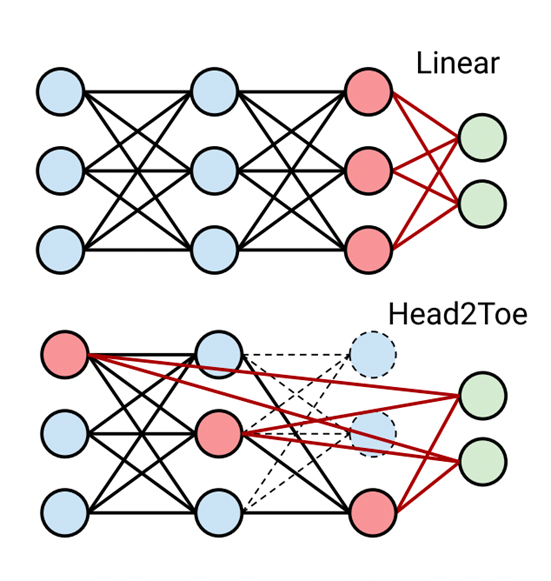

**Head2Toe** dose not like linear probes, it put some of the linear layers' neurons in the hidden layers. Inside the hidden layers, we select our own paths(we deactivate some not importand neurons. The purpose is to create a connection from a linear probe to importand features. We try to select imporant features only. This can be done by using **group-lasso regularization**. 

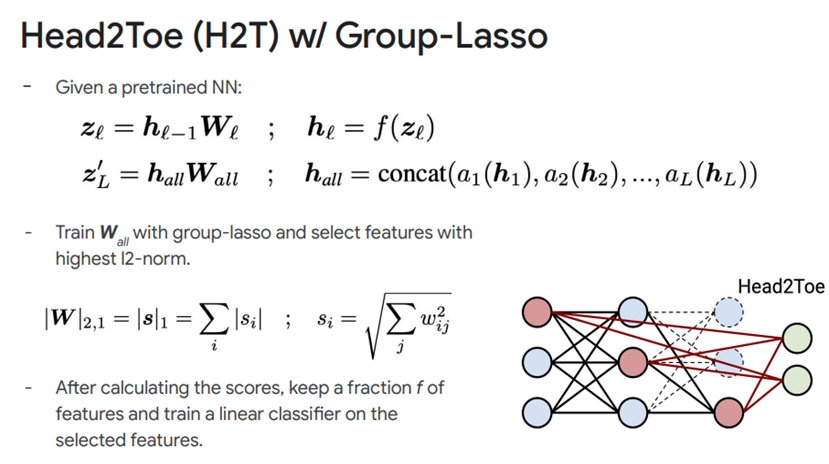

The formula of Head2toe + Group-Lasso is shown as above. From the source codes of Head2toe from https://github.com/google-research/head2toe, we can see all samples(finetune.py, finetune_fs.py, finetune_h2t.py) use group-lasso regularizer.

In [17]:
# coding=utf-8
# Copyright 2022 Head2Toe Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""Default configutation."""
import re
from ml_collections import ConfigDict


def get_config(config_string):
  train_batch_size = 128
  eval_batch_size = 50
  config = ConfigDict({
      'dataset':
          'data.caltech101',
      'eval_mode':
          'valid',
      'is_vtab_5fold_valid':
          True,
      'seed':
          8,
      'max_num_gpus':
          1,
      'learning':
          ConfigDict({
              'optimizer': 'adam',  #  adadelta, adadelta_adaptive, sgd
              'learning_rate': 0.1,
              'grad_clip_value': -1.,  # Applied if positive.
              'l1_regularizer': 0.,
              'l2_regularizer': 0.,
              'group_lrp_regularizer_coef': 0.,
              'group_lrp_regularizer_r': 2.,
              'group_lrp_regularizer_p': 1.,
              'group_lrp_is_embedding': False,
              'training_steps': 500,
              'data_fraction': 1.,
              'cached_eval': True,
              'use_cosine_decay': True,
              'train_batch_size': train_batch_size,
              'eval_batch_size': eval_batch_size,
              'finetune_backbones': False,
              'finetune_lr_multiplier': 1.,
              'finetune_steps_multiplier': 1.,
              # ('', 'unit_vector', 'per_feature')
              'feature_normalization': 'unit_vector',
              # nohidden, random_100, random_1000, trainable_100, trainable_1000
              'output_head_type': 'nohidden',
              'output_head_zeroinit': False,
              'log_freq': 50,
          }),
      'model_name':
          'Finetune'
  })

  config.backbone = get_backbone_config(config_string)
  print(f'Config backbone: {config.backbone}')
  #return config
  new_learning_config = ConfigDict({
    'feature_selection':
        ConfigDict({
            # Following types exist: 'connectivity_mask',
            # 'connectivity_l1', 'random', 'none', 'variance' and
            # 'sklearn_x' where x in
            # [chi2, f_classif, mutual_info_classif, trees]
            'type': 'none',
            'fs_dataset': '',
            'is_overwrite': False,
            'average_over_k': 1,
            'keep_fraction': 0.1,
            'keep_fraction_offset': 0,
            'mean_interpolation_coef': 0.,
            'learning_config_overwrite':
                ConfigDict({
                    'group_lrp_regularizer_coef': 1e-4,
                    'finetune_backbones': False,
                })
        }),
    })
  config['learning'].update(new_learning_config)
  print(f'Config backbone: {config.backbone}')
  #return config
  if 'imagenetr50' in config_string:
    all_blocks = set({'after_root', 'logits', 'pre_logits_pre_pooling'})
    for i, j in enumerate([3, 4, 6, 3]):
      for k in range(j):
        for l in range(3):
          all_blocks.add(f'block{i+1}_unit{k+1}_layer{l}')
  elif 'imagenetvitB16' in config_string:
    all_blocks = set({'cls_embedded', 'encoded_sequence',
                      'position_embedded_input', 'root_output_with_cls'})
    for i in range(12):
      all_blocks.add(f'encoder_{i}_attn')
      all_blocks.add(f'encoder_{i}_mlp_1')
      all_blocks.add(f'encoder_{i}_mlp_2')
      all_blocks.add(f'encoder_{i}_pre_attn')
  else:
    raise ValueError(f'This config is not supported for {config_string}')
  config.backbone.additional_features = ','.join(all_blocks)
  config.learning.feature_selection.type = 'connectivity_l2'
  config.learning.feature_selection.is_overwrite = True
  print(f'Config backbone: {config.backbone}')
  return config

def get_backbone_config(config_string):
  """Gets backbone configuration according to the key given."""
  # Example patterns:
  # imagenetr50, imagenetr50_2x
  pattern = r'^([A-Za-z0-9]+)?_?(\d+)?x?'
  searched = re.search(pattern, config_string)
  if not searched:
    raise ValueError(f'Unrecognized config_string: {config_string}')
  added_backbone, n_repeat = searched.groups()
  print(f'Split config: {added_backbone}, {n_repeat}')
  processed_names = []
  processed_handles = []
  processed_signatures = []
  processed_output_keys = []
  input_sizes = tuple()

  if added_backbone in SINGLE_MODELS:
    n_repeat = int(n_repeat) if n_repeat else 1
    processed_names += [added_backbone] * n_repeat
    handle, size = SINGLE_MODELS[added_backbone]
    if isinstance(handle, list):
      processed_handles = handle * n_repeat
      processed_handles = processed_handles[:n_repeat]
    else:
      processed_handles += [handle] * n_repeat

    if 'vit' in added_backbone:
      processed_signatures += ['serving_default'] * n_repeat
      processed_output_keys += ['pre_logits'] * n_repeat
    else:
      processed_signatures += ['representation'] * n_repeat
      processed_output_keys += ['pre_logits'] * n_repeat
    input_sizes += (size,) * n_repeat
  else:
    raise ValueError(f'added_backbone:{added_backbone} is not recognized')

  return ConfigDict({
      'names': processed_names,
      'handles': processed_handles,
      'signatures': processed_signatures,
      'output_keys': processed_output_keys,
      'input_sizes': input_sizes,
      'include_input': False,
      'additional_features': '',
      'additional_features_pool_size': 0,
      'cls_token_pool': 'normal',
      # If target size is provided, pool size is ignored.
      'additional_features_target_size': 0,
      'additional_features_multi_target_sizes': '',
  })


SINGLE_MODELS = {
    'imagenetr50': ('imagenetr50/', 240),
    'imagenetvitB16': ('imagenetvitB16/', 224)
}

In [18]:
config = get_config('imagenetr50')

Split config: imagenetr50, None
Config backbone: additional_features: ''
additional_features_multi_target_sizes: ''
additional_features_pool_size: 0
additional_features_target_size: 0
cls_token_pool: normal
handles:
- imagenetr50/
include_input: false
input_sizes: !!python/tuple
- 240
names:
- imagenetr50
output_keys:
- pre_logits
signatures:
- representation

Config backbone: additional_features: ''
additional_features_multi_target_sizes: ''
additional_features_pool_size: 0
additional_features_target_size: 0
cls_token_pool: normal
handles:
- imagenetr50/
include_input: false
input_sizes: !!python/tuple
- 240
names:
- imagenetr50
output_keys:
- pre_logits
signatures:
- representation

Config backbone: additional_features: block3_unit6_layer2,block4_unit1_layer0,block3_unit3_layer0,pre_logits_pre_pooling,block2_unit4_layer2,block2_unit2_layer2,block4_unit2_layer1,block3_unit3_layer1,block4_unit2_layer0,block3_unit1_layer0,block2_unit2_layer1,block1_unit3_layer2,block3_unit2_layer1,block

As outputs we can see, this time we used Head2toe.

In [19]:
# define a Head2toe model
model = Finetune(config)

In [20]:
# perform prediction
result = model.evaluate(config.learning, dataset, dataset)

In [21]:
print(result)

{'support_loss': 1.7136148e-07, 'support_accuracy': 0.03125, 'query_loss': 4.3868536e-07, 'query_accuracy': 0.08}
